In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#import pandas as pd
import os
import cv2

import io, pyopenlpt as lpt

redirector = lpt.PythonStreamRedirector()

import pybind11
print(np.__version__)
# print(pd.__version__)
print(pybind11.__version__)
print("using:", lpt.__file__)


2.3.5
2.13.0
using: c:\Users\tan_s\miniconda3\envs\OpenLPT\Lib\site-packages\pyopenlpt.cp311-win_amd64.pyd


In [2]:
# read config
config_file ="I:\\VONSET\\Data\\20221123\\T1\\Processed\\config.txt" #'../../test/inputs/test_STB/config_python.txt'
basic_settings = lpt.BasicSetting()
basic_settings.readConfig(config_file)
print(dir(basic_settings))  # 查看有哪些属性

for name in dir(basic_settings):
    if not name.startswith("__"):  # 跳过内置方法
        try:
            print(name, "=", getattr(basic_settings, name))
        except Exception:
            pass


['__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '_axis_limit', '_cam_list', '_fps', '_frame_end', '_frame_start', '_image_file_paths', '_load_track', '_load_track_frame', '_load_track_path', '_n_cam', '_n_thread', '_object_config_paths', '_object_types', '_output_path', '_voxel_to_mm', 'readConfig']
_axis_limit = <pyopenlpt.AxisLimit object at 0x0000013FED6DE730>
_cam_list = [<Camera type=0 active=True size=1280x800>, <Camera type=0 active=True size=1280x800>, <Camera type=0 active=True size=1280x800>, <Camera type=0 active=True size=1280x800>]
_fps = 1000
_frame_end = 999
_frame_start = 0
_image_file_paths = ['I:/VONSET/Data/20221123/T1/Processed/imgFile/cam0ImageNames.txt', 'I:/VONSET/Data/20221123/T1/P

In [3]:
# confirm camera parameters
cam_list = basic_settings._cam_list
print("There are", len(cam_list), "cameras.")

# 打印第2个相机参数
cam2 = cam_list[1]   # Python 从0开始索引
print("Camera 2 =", cam2)

# 可以进一步展开相机的参数
print("  active =", cam2._is_active)
print("  type   =", cam2._type)
print("  max_intensity =", cam2._max_intensity)

# 打印 pinhole 内参矩阵等
p = cam2._pinhole_param
print("  image size =", p.n_row, "x", p.n_col)
print("  cam_mtx =", p.cam_mtx.to_list())
print("  distortion coeffs =", p.dist_coeff)
print("  R =", p.r_mtx.to_list())
print("  T =", p.t_vec)

There are 4 cameras.
Camera 2 = <Camera type=0 active=True size=1280x800>
  active = True
  type   = CameraType.PINHOLE
  max_intensity = 255.0
  image size = 800 x 1280
  cam_mtx = [[29116.12625981, 0.0, 590.0007518812153], [0.0, 29116.12625981, 448.9195078196408], [0.0, 0.0, 1.0]]
  distortion coeffs = [0.0, 0.0, 0.0, 0.0, 0.0]
  R = [[-0.017704656546161622, 0.11257322937717099, -0.9934856884546336], [-0.09540341171461145, 0.9889174969621888, 0.1137557613277307], [0.9952812337072344, 0.0967959308526662, -0.006768574485891746]]
  T = <Pt3D (1.765682,-0.916361,1139.698859)>


In [4]:
from pprint import pprint

tr_cfg = lpt.TracerConfig()
tr_cfg.readConfig(basic_settings._object_config_paths[0], basic_settings)

# 子结构字段白名单
SUBFIELDS = {
    "IPRParam": [
        "n_cam_reduced", "n_loop_ipr", "n_loop_ipr_reduced", "n_obj2d_process_max"
    ],
    "PFParam": [
        "limit", "nx", "ny", "nz", "r",
        "nBin_x", "nBin_y", "nBin_z",
        "is_smooth", "sigma_x", "sigma_y", "sigma_z"
    ],
    "SMParam": [
        "match_cam_count", "idmap_cell_px", "tol_2d_px", "tol_3d_mm"
    ],
    "ShakeParam": [
        "_shake_width", "_n_shake_loop", "_thred_ghost", "_shakewidth_min", "_ratio_augimg"
    ],
    "STBParam": [
        "_radius_search_obj", "_n_initial_frames", "_radius_search_track"
    ],
}

# Config（派生 + 基类）的候选字段（存在就取）
CONFIG_CANDIDATES = [
    # TracerConfig 自身
    "_min_obj_int", "_radius_obj", "_otf",
    # ObjectConfig 基类
    "_n_thread", "_stb_param", "_shake_param", "_pf_param", "_ipr_param", "_sm_param",
]

def _maybe_extract(obj):
    """递归展开已知的子结构；否则返回原值或字符串"""
    tname = type(obj).__name__
    if tname in SUBFIELDS:
        out = {}
        for name in SUBFIELDS[tname]:
            out[name] = getattr(obj, name)
        return out
    return obj  # 对未列白名单的类型（如 OTF）直接返回对象本身

def tracer_cfg_to_dict(tr_cfg):
    d = {}
    # 合并派生类 + 基类字段（存在就读）
    for name in CONFIG_CANDIDATES:
        if hasattr(tr_cfg, name):
            val = getattr(tr_cfg, name)
            d[name] = _maybe_extract(val)
    # kind 是只读属性
    d["kind"] = tr_cfg.kind
    return d

# 用法
pprint(tracer_cfg_to_dict(tr_cfg), sort_dicts=False, width=100)


{'_min_obj_int': 30,
 '_radius_obj': 2.0,
 '_otf': <pyopenlpt.OTF object at 0x0000013FEDA49570>,
 '_stb_param': {'_radius_search_obj': 0.44999999999999996,
                '_n_initial_frames': 4,
                '_radius_search_track': 1.3499999999999999},
 '_shake_param': {'_shake_width': 0.01125,
                  '_n_shake_loop': 4,
                  '_thred_ghost': 0.1,
                  '_shakewidth_min': 0.0005625,
                  '_ratio_augimg': 2},
 '_pf_param': {'limit': <pyopenlpt.AxisLimit object at 0x0000013FEFF64B30>,
               'nx': 51,
               'ny': 51,
               'nz': 51,
               'r': 1.125,
               'nBin_x': 11,
               'nBin_y': 11,
               'nBin_z': 11,
               'is_smooth': True,
               'sigma_x': 1.0,
               'sigma_y': 1.0,
               'sigma_z': 1.0},
 '_ipr_param': {'n_cam_reduced': 1,
                'n_loop_ipr': 4,
                'n_loop_ipr_reduced': 2,
                'n_obj2d_process_

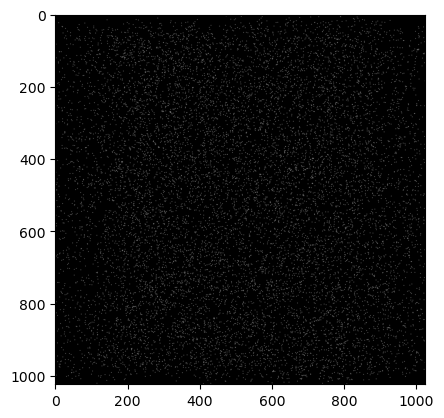

In [5]:
# create ImageIO instances for each image path
imgio_list = []
for path in basic_settings._image_file_paths:
    io = lpt.ImageIO()
    io.loadImgPath("", path)
    imgio_list.append(io)

num_cams = len(imgio_list)
frame_id = 0

image_list = []
for i in range(num_cams):
    image_list.append(imgio_list[i].loadImg(frame_id))

arr = np.array(image_list[0].to_list(), dtype=np.uint8)

plt.imshow(arr, cmap="gray")
plt.show()

Camera 0: found 11679 objects.
Camera 1: found 11470 objects.
Camera 2: found 11462 objects.
Camera 3: found 11331 objects.


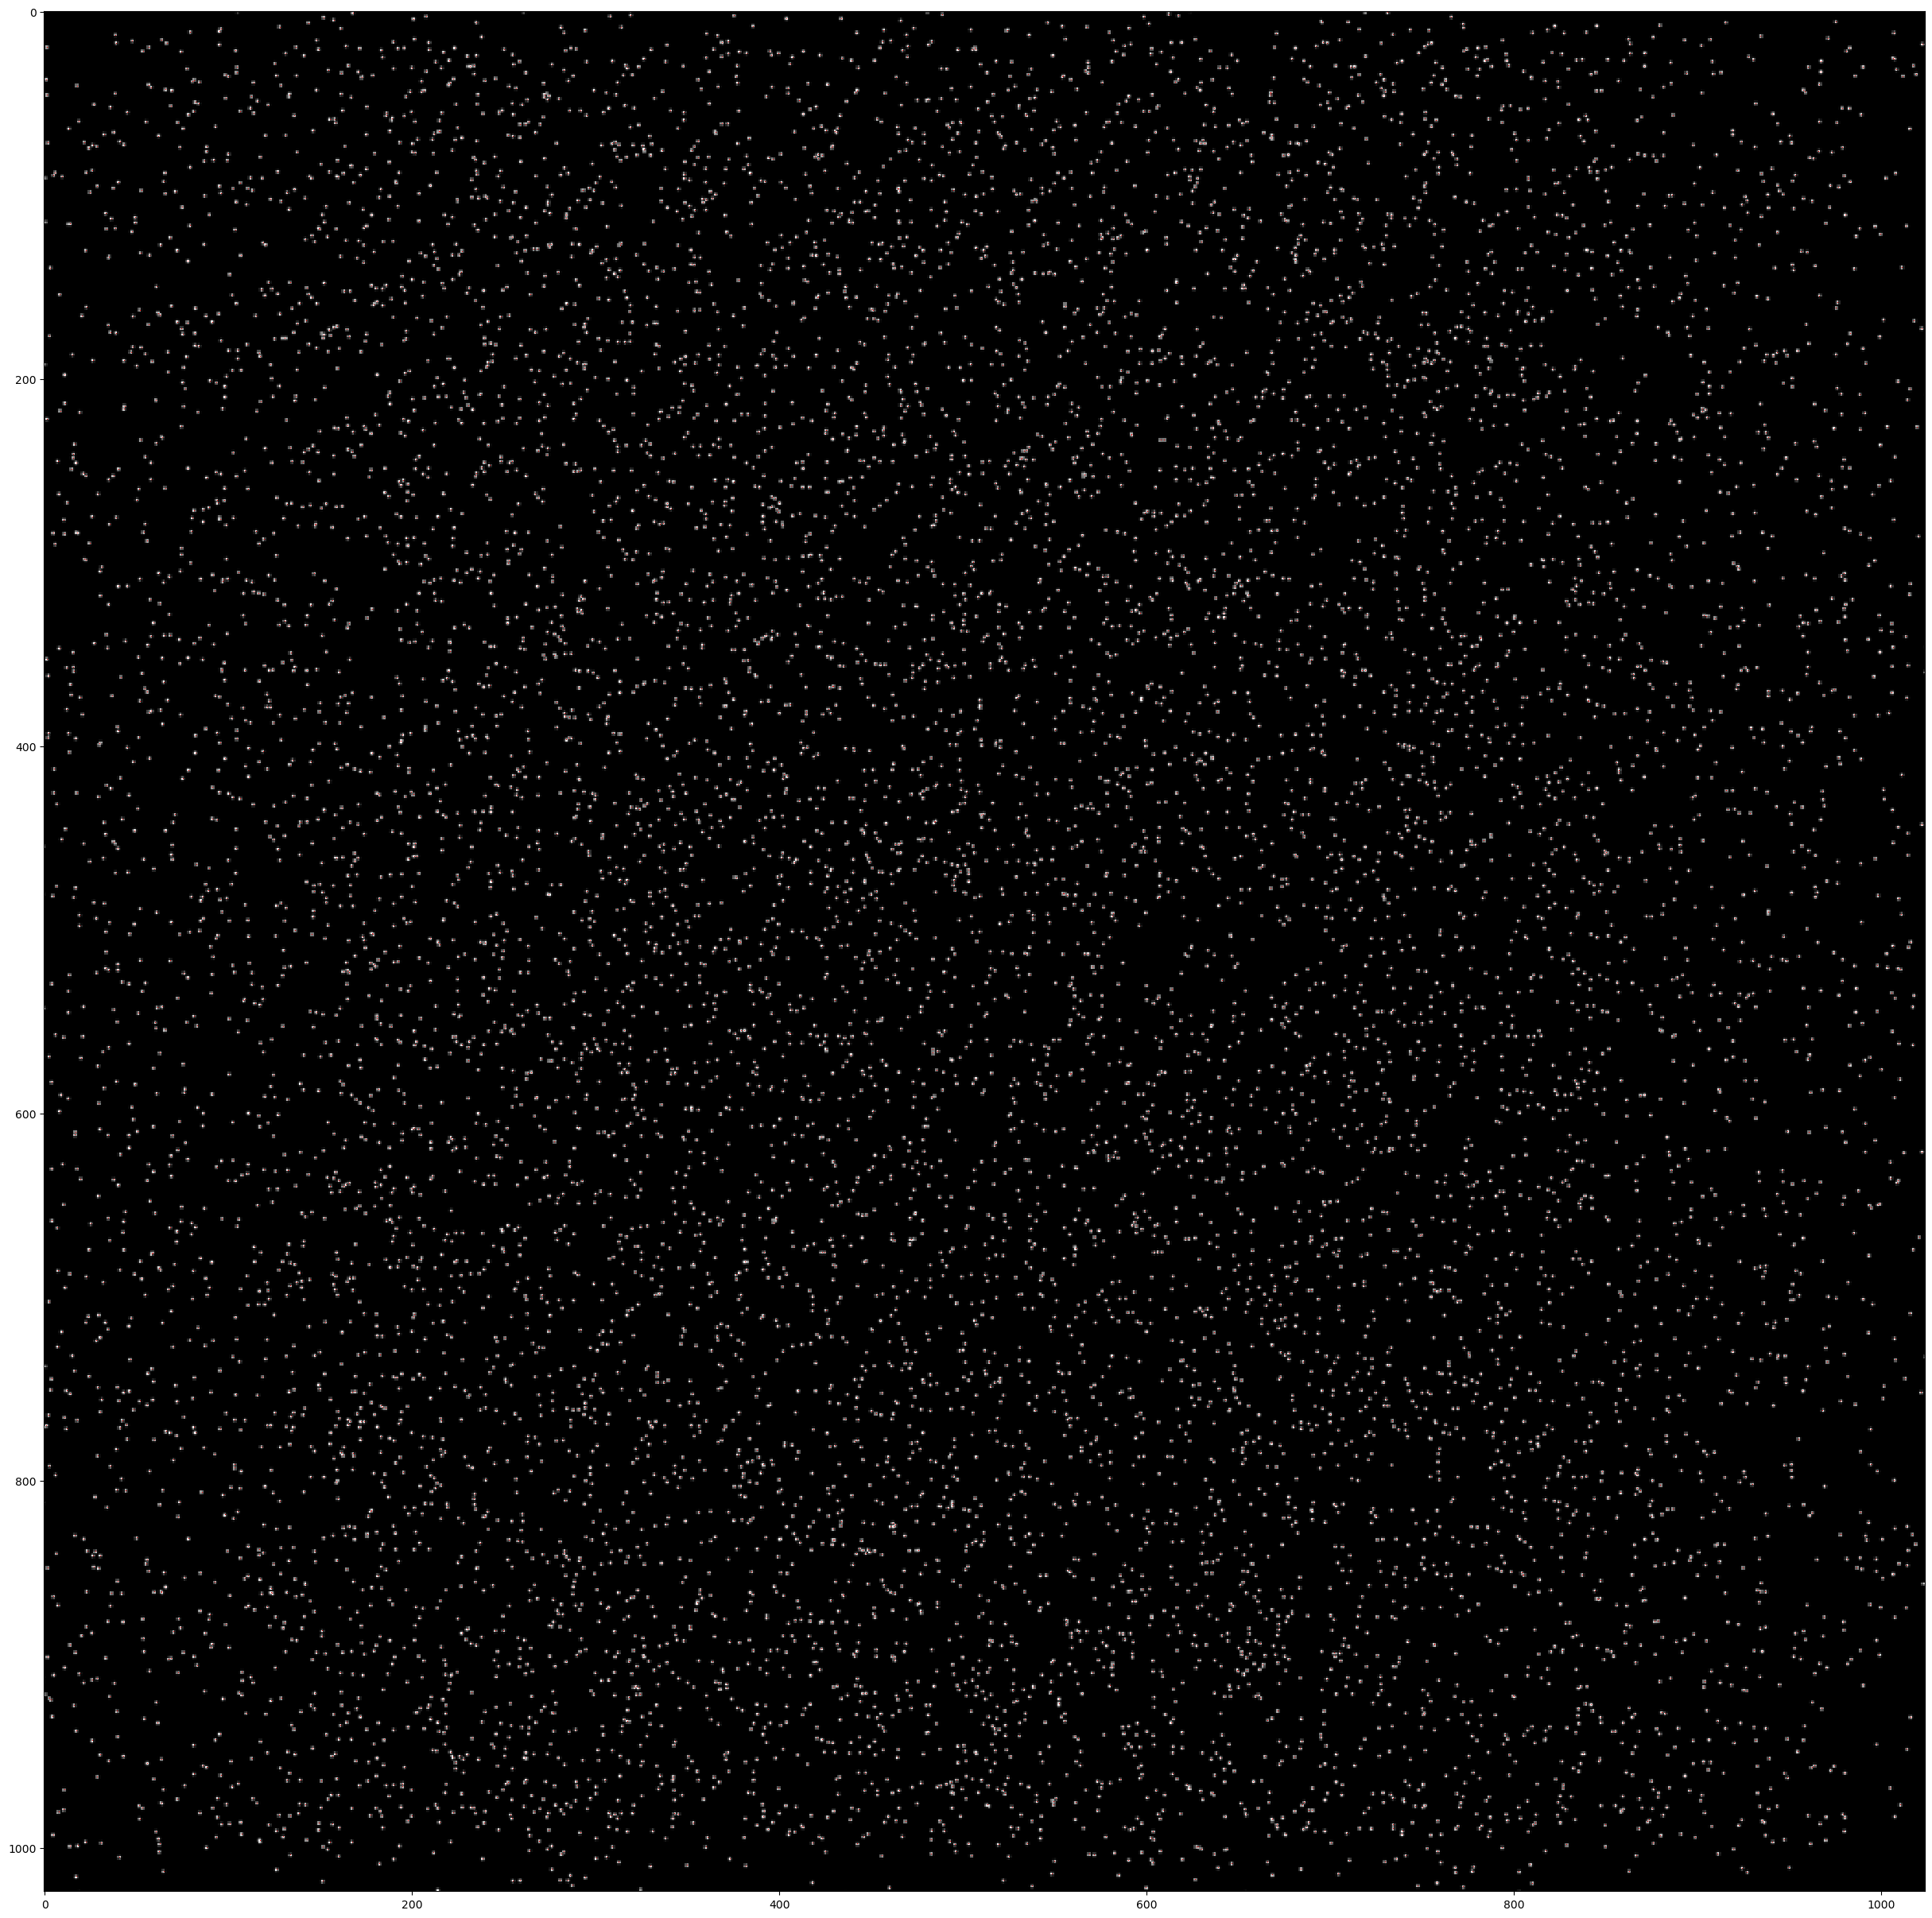

: 

In [ ]:
obj_finder = lpt.ObjectFinder2D()
n_cams = len(cam_list)
obj2d_list = []
for cam_id in range(n_cams):
    obj2ds = obj_finder.findObject2D(image_list[cam_id], tr_cfg)
    obj2d_list.append(obj2ds)
    print(f"Camera {cam_id}: found {len(obj2ds)} objects.")

img = np.array(image_list[1].to_list(), dtype=np.uint8)
points = obj2d_list[1]
xs = [p._pt_center[0] for p in points]
ys = [p._pt_center[1] for p in points]

def show_pixels(img, xs=None, ys=None, scale=1.0):
    """
    零边距像素级显示：
      - scale：把图在屏幕上按倍数放大（不改变数据像素）
    """
    H, W = img.shape[:2]
    dpi = plt.rcParams.get('figure.dpi', 100)
    fig_w = (W * scale) / dpi
    fig_h = (H * scale) / dpi

    plt.figure(figsize=(fig_w, fig_h), dpi=dpi, frameon=False)

    plt.imshow(img, cmap='gray', interpolation='nearest')
    if xs is not None and ys is not None:
        plt.plot(xs, ys, 'r,', markersize=1)  # 像素级标记

    plt.show()

show_pixels(img, xs, ys, scale=3.0)

Matched 9520 3D objects.
obj#0: total cams=4, valid 2D=3, cams=[1, 2, 3]
obj#1: total cams=4, valid 2D=3, cams=[0, 2, 3]
obj#2: total cams=4, valid 2D=3, cams=[0, 2, 3]
obj#3: total cams=4, valid 2D=3, cams=[0, 2, 3]
obj#4: total cams=4, valid 2D=3, cams=[1, 2, 3]
obj#5: total cams=4, valid 2D=3, cams=[0, 2, 3]
obj#6: total cams=4, valid 2D=3, cams=[0, 2, 3]
obj#7: total cams=4, valid 2D=3, cams=[0, 2, 3]
obj#8: total cams=4, valid 2D=3, cams=[0, 2, 3]
obj#9: total cams=4, valid 2D=3, cams=[0, 2, 3]
2D points on all cameras for the first matched 3D object: [None, <Pt2D (503.963360,192.084448)>, <Pt2D (398.547054,220.296913)>, <Pt2D (605.054328,225.030181)>]
2D points on all cameras for the first matched 3D object: [<Pt2D (369.865152,209.624927)>, <Pt2D (503.963446,192.084496)>, <Pt2D (398.547105,220.296837)>, <Pt2D (605.054404,225.030211)>]


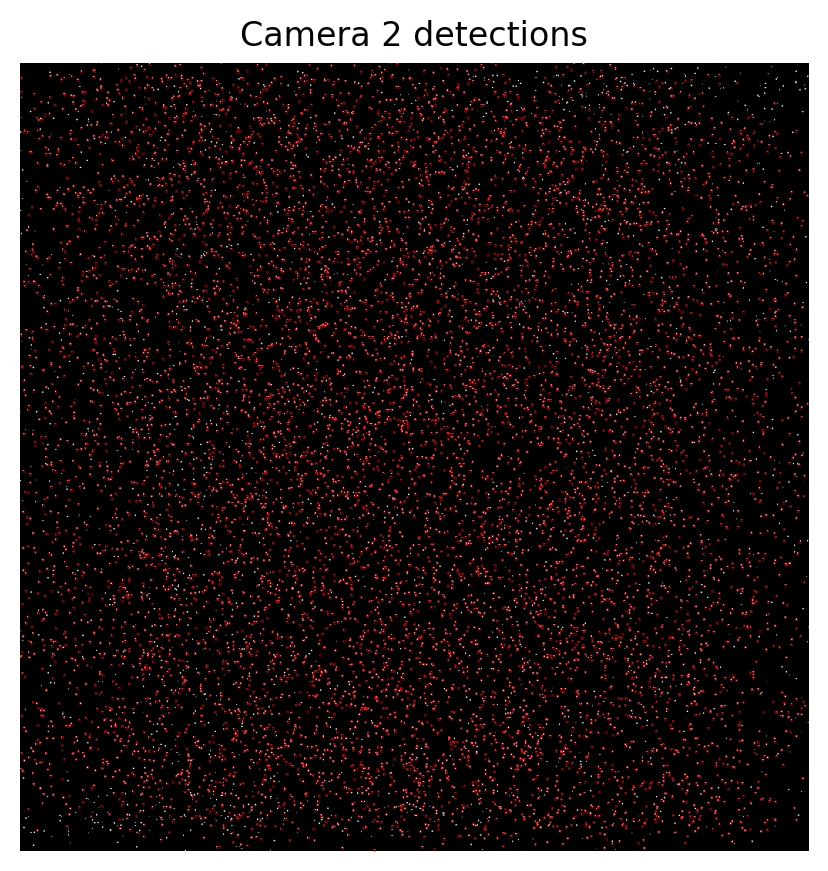

In [7]:
# test stereo matching
stereomath = lpt.StereoMatch(cam_list, obj2d_list, tr_cfg)
obj3d_list = stereomath.match()
print(f"Matched {len(obj3d_list)} 3D objects.")

# only match_cam_count cams have valid 2D projections
n_check = min(10, len(obj3d_list))

for i, obj in enumerate(obj3d_list[:n_check]):
    valid_cams = [c for c, o2d in enumerate(obj._obj2d_list) if o2d is not None]
    n_valid = len(valid_cams)
    print(f"obj#{i}: total cams={len(obj._obj2d_list)}, valid 2D={n_valid}, cams={valid_cams}")

obj = obj3d_list[0]
print("2D points on all cameras for the first matched 3D object:", [o._pt_center if o is not None else None for o in obj._obj2d_list])
obj.projectObject2D(cam_list)
print("2D points on all cameras for the first matched 3D object:", [o._pt_center for o in obj._obj2d_list])

for obj in obj3d_list:
    obj.projectObject2D(cam_list) # you need to calculate 2D projections for all cameras

# plot the 2D detections of stereo matched objects on camera 2
xs = [obj._obj2d_list[1]._pt_center[0] for obj in obj3d_list]
ys = [obj._obj2d_list[1]._pt_center[1] for obj in obj3d_list]

img = np.array(image_list[1].to_list(), dtype=np.uint8)
h, w = img.shape[:2]
dpi = 200
figsize = (w / dpi, h / dpi)

plt.figure(figsize=figsize, dpi=dpi)
plt.imshow(img, cmap='gray', interpolation='none')

# 打印红点
plt.scatter(xs, ys, c='r', s=.05, marker='.')

plt.title("Camera 2 detections")
plt.axis("off")
plt.show()

number of objects in GT: 12500, reconstructed: 9520
real=9494, ghosts=26
repeated rec points: 2


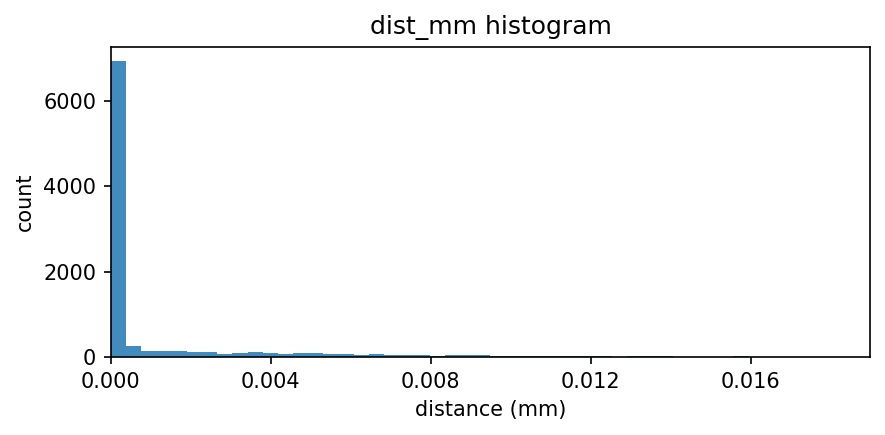

In [8]:
# check ghost objs
import sys, pathlib
repo_root = pathlib.Path.cwd().parent          # for finding openLPT_utils
sys.path.insert(0, str(repo_root))

import numpy as np
from scipy.io import loadmat
from openLPT_utils.ghost_eval import find_ghosts
import matplotlib.pyplot as plt


# check the ghost objs from the stereomatch step
track_path = '../../test/solutions/tracks_12k5_coarse_250frames.mat'
tracks = loadmat(track_path)['tracks']  

pts_groundtrue = tracks[tracks[:, 3] == 1, :3].astype(np.float32)

print(f"number of objects in GT: {len(pts_groundtrue)}, reconstructed: {len(obj3d_list)}")
pts_reconstructed = np.array(
    [[obj._pt_center[0], obj._pt_center[1], obj._pt_center[2]] for obj in obj3d_list], 
    dtype=np.float32)

tol_mm = 1 * .04
cmp_st = find_ghosts(pts_groundtrue, pts_reconstructed, tol_mm, use_ckdtree=True)

print(f"real={len(cmp_st['matched_indices'])}, ghosts={len(cmp_st['ghost_indices'])}")

print(f"repeated rec points: {len(cmp_st['repeated_indices'])}")
for k, rec_idxs in list(cmp_st["gt_to_rec"].items())[:20]:
    if len(rec_idxs) >= 2:
        print(f"GT #{k} <- rec {rec_idxs.tolist()}")

from matplotlib.ticker import FormatStrFormatter, MaxNLocator

d = np.asarray(cmp_st['dist_mm'], float)
d = d[np.isfinite(d)]
if d.size == 0:
    print("dist_mm 为空")
else:
    p99 = np.percentile(d, 99)           # 只看前 99%，避免长尾挤压
    xmin, xmax = 0.0, p99
    bin_count = 50                       # 想更平滑就调大/调小

    fig, ax = plt.subplots(figsize=(6, 3), dpi=150)
    ax.hist(d, bins=bin_count, range=(xmin, xmax), density=False, alpha=0.85)
    if 'tol_mm' in globals():
        ax.axvline(float(tol_mm), ls='--')
    ax.set_xlim(xmin, xmax)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))  # 一位小数
    ax.xaxis.set_major_locator(MaxNLocator(nbins=6))          # 控制刻度数量
    ax.set_xlabel('distance (mm)')
    ax.set_ylabel('count')
    ax.set_title('dist_mm histogram')
    plt.tight_layout(); plt.show()

CameraType.PINHOLE
ghost: 0 repeated: 1
[0.357050137397349, 0.15450850087816664, 1.0311039466531762, 0.35688609262943244, 0.3430468496566114, 4.780279457143867, 0.8103494075748379, 0.14680717423731374, 1.9796880686035871, 1.352475537490758, 2.8637572896126597, 6.281992932967361, 0.11873770952441492, 1.1751526372778118, 1.6395456871057934, 0.7811732132792024, 0.6617281317707027, 0.974866232564243, 1.0491978461681868, 0.36921661753348994, 0.22826443268212016, 0.5640021464064399, 0.4747962428466068, 1.531871069937915, 1.1585415729718525, 0.16246521376908502]
mean of scores: 0.8889521879160129
minimum of ghost scores: 0.11873770952441492


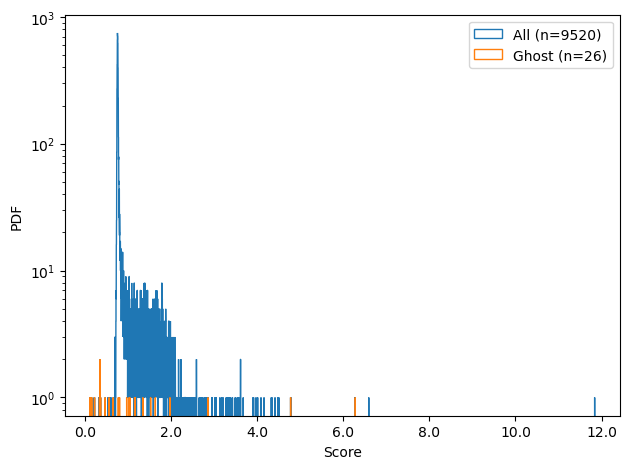

In [9]:
# test shake

shaker = lpt.Shake(cam_list, tr_cfg)
print(shaker.cams[0]._type)

flags, obj3d_list_shaked = shaker.runShake(obj3d_list, image_list)
arr = np.asarray([int(f) for f in flags])  
n_ghost    = int(np.count_nonzero(arr & int(lpt.ObjFlag.Ghost)))
n_repeated = int(np.count_nonzero(arr & int(lpt.ObjFlag.Repeated)))
print("ghost:", n_ghost, "repeated:", n_repeated)

score_list = shaker.score_list
ghost_score = [score_list[i] for i in cmp_st['ghost_indices']]
print(ghost_score)

# plot PDF of score list and ghost score
from matplotlib.ticker import MaxNLocator, FormatStrFormatter

scores = np.asarray(score_list, dtype=float)
print("mean of scores:", np.mean(scores))

print("minimum of ghost scores:", np.min(ghost_score))
gi = np.asarray(cmp_st['ghost_indices'])

# If ghost_indices is a boolean mask, convert to integer indices
if gi.dtype == bool:
    gi = np.flatnonzero(gi)

ghost_scores = scores[gi] if gi.size else np.array([])

# Freedman–Diaconis bins (robust, shared for both PDFs)
def fd_bins(x):
    x = x[np.isfinite(x)]
    if x.size < 2:
        return 10
    iqr = np.subtract(*np.percentile(x, [75, 25]))
    bw = 2 * iqr * (x.size ** (-1/3))
    if bw <= 0:
        return 10
    return max(10, int(np.ceil((x.max() - x.min()) / bw)))

bins = fd_bins(scores)
pdf_all, edges = np.histogram(scores, bins=bins, density=True)
centers = 0.5 * (edges[:-1] + edges[1:])

plt.figure()
plt.hist(scores,bins=edges, density=False, histtype='step', label=f'All (n={scores.size})')

if ghost_scores.size:
    plt.hist(ghost_scores, bins=edges, density=False, histtype='step', label=f'Ghost (n={ghost_scores.size})')

ax = plt.gca()
ax.set_yscale("log")
ax.xaxis.set_major_locator(MaxNLocator(nbins=8))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.xlabel('Score')
plt.ylabel('PDF')
plt.legend()
plt.tight_layout()
plt.show()


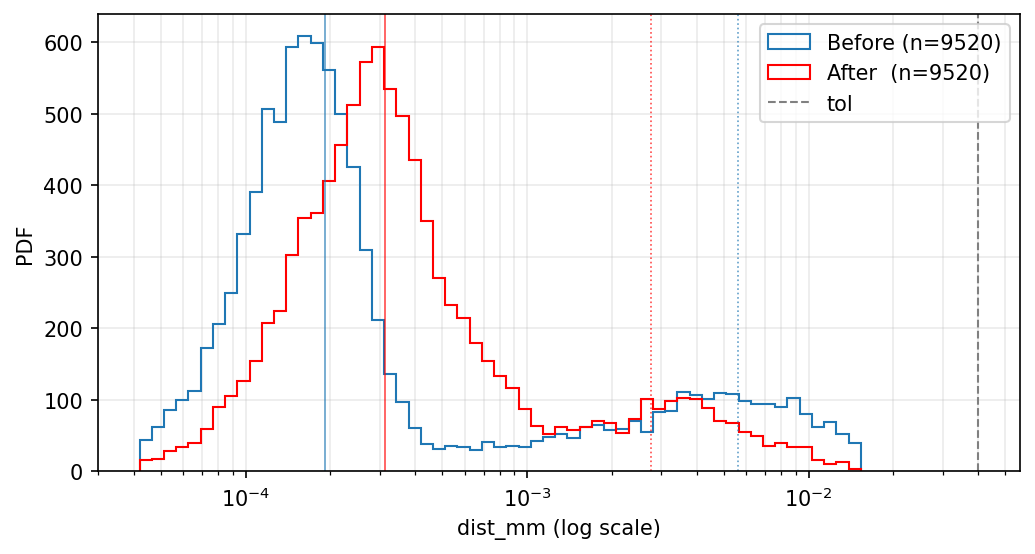

median:  before=0.000191 mm  ->  after=0.000313 mm  (+64.4%)
P90:     before=0.00562 mm ->  after=0.00276 mm (-50.9%)


In [10]:
# plot the position uncertianty after shaking
pts_shaked = np.array(
    [[obj._pt_center[0], obj._pt_center[1], obj._pt_center[2]] for obj in obj3d_list_shaked], 
    dtype=np.float32)
tol_mm = 1 * .04
cmp_shake = find_ghosts(pts_groundtrue, pts_shaked, tol_mm, use_ckdtree=True)

def clean_pos(x):
    x = np.asarray(x, float).ravel()
    return x[np.isfinite(x) & (x > 0.0)]  # log 轴不能有 <=0

d0 = clean_pos(cmp_st['dist_mm'])        # before shake
d1 = clean_pos(cmp_shake['dist_mm'])  # after  shake
if d0.size == 0 or d1.size == 0:
    print(f"Empty dist_mm: before={d0.size}, after={d1.size}")
else:
    # shared log-spaced bins on a robust range (1–99 percentile of both)
    all_pos = np.concatenate([d0, d1])
    lo = np.percentile(all_pos, 1)
    hi = np.percentile(all_pos, 99)
    lo = max(lo, np.min(all_pos))     # guard
    edges = np.logspace(np.log10(lo), np.log10(hi), 60)

    fig, ax = plt.subplots(figsize=(7, 3.8), dpi=150)
    ax.hist(d0, bins=edges, density=False, histtype='step', label=f'Before (n={d0.size})')
    ax.hist(d1, bins=edges, density=False, color = 'red', histtype='step', label=f'After  (n={d1.size})')

    ax.set_xscale('log')
    ax.set_xlabel('dist_mm (log scale)')
    ax.set_ylabel('PDF')

    # Reference lines: tolerance, medians, P90
    if 'tol_mm' in globals() and tol_mm and tol_mm > 0:
        ax.axvline(float(tol_mm), color='gray', ls='--', lw=1, label='tol')

    m0, m1 = np.median(d0), np.median(d1)
    p90_0, p90_1 = np.percentile(d0, 90), np.percentile(d1, 90)
    ax.axvline(m0,  ls='-',  lw=0.8, alpha=0.7)
    ax.axvline(m1,  ls='-',  color = 'red', lw=0.8, alpha=0.7)
    ax.axvline(p90_0, ls=':', lw=0.8, alpha=0.7)
    ax.axvline(p90_1, ls=':', color = 'red', lw=0.8, alpha=0.7)

    ax.legend()
    ax.grid(True, which='both', alpha=0.25)
    plt.tight_layout()
    plt.show()

    print(f"median:  before={m0:.3g} mm  ->  after={m1:.3g} mm  ({(m1/m0-1)*100:+.1f}%)")
    print(f"P90:     before={p90_0:.3g} mm ->  after={p90_1:.3g} mm ({(p90_1/p90_0-1)*100:+.1f}%)")

7954 0.02422045726834522
2.0
0.03008834522319192 0.02422045726834522
<Pt3D (12.815812,2.558266,-9.079510)> <Pt3D (12.808719,2.559844,-9.079012)> <Pt3D (12.794528,2.577547,-9.070536)>


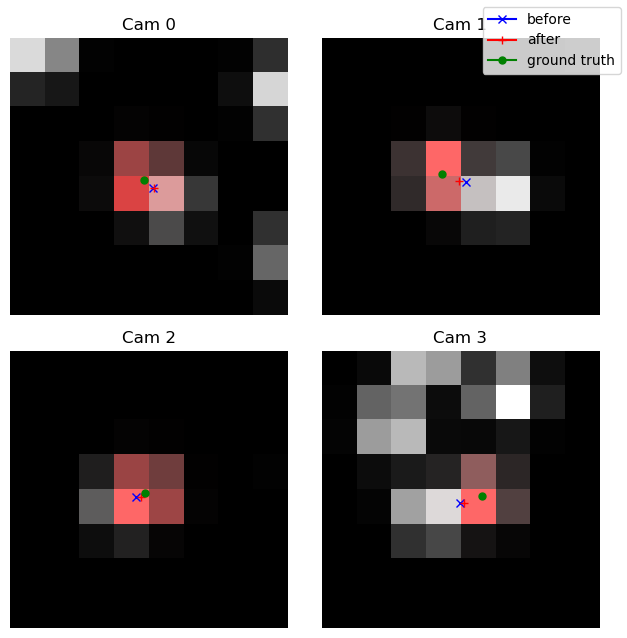

In [ ]:
#debug on why the position error increases
real_obj_index = cmp_shake["matched_indices"]
obj_ind = real_obj_index[int(np.argmax(cmp_shake["dist_mm"][real_obj_index]))]
error_pos = cmp_shake["dist_mm"][obj_ind]
print(obj_ind, error_pos)

pt_gt = pts_groundtrue[cmp_shake["rec_to_gt"][obj_ind]]
obj_gt = lpt.Tracer3D(lpt.Pt3D(pt_gt[0], pt_gt[1], pt_gt[2]), tr_cfg._radius_obj)
obj_gt.projectObject2D(cam_list)

e_bf = cmp_st["dist_mm"][obj_ind]
e_af = cmp_shake["dist_mm"][obj_ind]
print(e_bf, e_af)
obj_bf = obj3d_list[obj_ind]
obj_af = obj3d_list_shaked[obj_ind]
print(obj_bf._pt_center, obj_af._pt_center, obj_gt._pt_center)

import math

strat = shaker.strategy

# use Shake to compute ROI bounds for this object (absolute pixel coordinates)
roi_all = shaker.buildROIInfo(obj_bf, image_list)  # one ROIInfo per camera

import matplotlib.colors as mcolors

# —— 前面保持你的对象选择、构造 obj_gt / ROI 等步骤不变 —— #

n_cam = len(image_list)
cols = min(2, n_cam)
rows = int(np.ceil(n_cam / cols))
fig, axes = plt.subplots(rows, cols, figsize=(3.2*cols, 3.2*rows))

# 让 axes 索引安全（兼容 1x1 / 1xn / nx1）
def get_ax(axes, r, c):
    if rows == 1 and cols == 1:
        return axes
    elif rows == 1:
        return axes[c]
    elif cols == 1:
        return axes[r]
    else:
        return axes[r, c]

# 颜色映射与透明度设置（你可换成 'viridis'/'magma'/'turbo' 等）
cmap = plt.get_cmap('plasma')
alpha_max = 0.65   # 叠加层的最大透明度
eps = 1e-12        # 防止全零归一化出 NaN

for k in range(n_cam):
    ax = get_ax(axes, k // cols, k % cols)

    # 原图 patch
    img_u8 = np.array(image_list[k].to_list(), dtype=np.uint8)
    roi = roi_all[k]
    rmin, rmax = roi.ROI_range.row_min, roi.ROI_range.row_max
    cmin, cmax = roi.ROI_range.col_min, roi.ROI_range.col_max
    patch = img_u8[rmin:rmax, cmin:cmax]  # 注意右开，不含 rmax/cmax

    # 计算投影 (与 patch 尺寸一致)
    rows_idx = np.arange(rmin, rmax, 1)
    cols_idx = np.arange(cmin, cmax, 1)
    proj = np.zeros((len(rows_idx), len(cols_idx)), dtype=float)
    for i, r in enumerate(rows_idx):
        for j, c in enumerate(cols_idx):
            proj[i, j] = strat.project2DInt(obj_gt, k, int(r), int(c))

    # —— 单色 + 固定 alpha 叠加 —— 
    proj_min, proj_max = np.min(proj), np.max(proj)
    proj_norm = (proj - proj_min) / (proj_max - proj_min + 1e-12)

    # 构造 RGBA：红色强度 ∝ proj_norm，alpha 也 ∝ proj_norm
    H, W = proj.shape
    overlay = np.zeros((H, W, 4), dtype=float)
    overlay[..., 0] = proj_norm           # R 通道
    overlay[..., 1] = 0.0                 # G 通道
    overlay[..., 2] = 0.0                 # B 通道
    overlay[..., 3] = proj_norm * 0.6     # Alpha 通道，0.6 为最大透明度

    # 先画灰度原图，再叠加彩色透明的投影
    ax.imshow(patch, cmap="gray", interpolation="nearest", origin="upper")
    ax.imshow(overlay, interpolation="nearest", origin="upper", vmin=0, vmax=125) # projection of the ground true

    # 画 before / after / GT 的 2D 点（坐标要减 ROI 偏移）
    x_bf = obj_bf._obj2d_list[k]._pt_center[0] 
    y_bf = obj_bf._obj2d_list[k]._pt_center[1]
    x_af = obj_af._obj2d_list[k]._pt_center[0]
    y_af = obj_af._obj2d_list[k]._pt_center[1] 
    x_gt = obj_gt._obj2d_list[k]._pt_center[0] 
    y_gt = obj_gt._obj2d_list[k]._pt_center[1]

    ax.plot(x_bf - cmin, y_bf - rmin, marker="x", color="blue",  markersize=6, label="before")
    ax.plot(x_af - cmin, y_af - rmin, marker="+", color="red",   markersize=6, label="after")
    ax.plot(x_gt - cmin, y_gt - rmin, marker="o", color="green", markersize=5, label="ground truth")

    ax.set_title(f"Cam {k}")
    ax.set_axis_off()

# 只放一个全局图例（取最后一个轴的句柄）
handles, labels = ax.get_legend_handles_labels()
if handles:
    fig.legend(handles, labels, loc="upper right", frameon=True)
plt.tight_layout()
plt.show()


<Pt3D (12.815812,2.558266,-9.079510)>
[94.95756047868076, 97.56529002144745, 96.25968488195484, 95.06789435163483, 94.77747541051099, 94.82827178755927]
<Pt3D (12.815812,2.558266,-9.079510)>


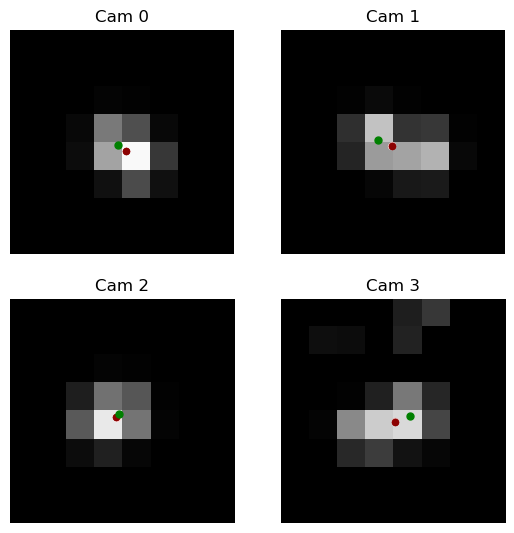

In [12]:
# simulate shake process step by step

import math

obj3d_list[obj_ind] = obj_bf
print(obj_bf._pt_center)
# create residue images
for obj in obj3d_list: # obj3d_list from stereomath.match()
    obj.projectObject2D(cam_list) # you need to calculate 2D projections for all cameras

fig, axes = plt.subplots(rows, cols, figsize=(3.2*cols, 3.2*rows))

delta = tr_cfg._shake_param._shake_width
delta_min = delta / 20

shake_cam = shaker.strategy.selectShakeCam(obj_bf, roi_all, image_list)

obj_shaked_history = []
residue_history = []
obj_shaked = obj_bf
for loop in range(6):
    shaker.calResidueImage(obj3d_list, image_list)
    # build augmented image
    roi_all = shaker.buildROIInfo(obj_shaked, image_list)
    residue, obj_shaked = shaker.shakeOneObject(obj_shaked, roi_all, delta, shake_cam)
    obj3d_list[obj_ind] = obj_shaked
    obj_shaked_history.append(obj_shaked)
    residue_history.append(residue)
    delta = delta / 2
    if delta < delta_min :
        delta = delta_min

print(residue_history)

import matplotlib.cm as cm
import matplotlib.colors as mcolors

T = len(obj_shaked_history)
start_rgb = np.array(mcolors.to_rgb("#ffd6d6"))
end_rgb   = np.array(mcolors.to_rgb("#8b0000"))
ts = np.linspace(0.0, 1.0, T if T > 1 else 1)
reds_rgba = [tuple(start_rgb*(1-t) + end_rgb*t) + (0.95,) for t in ts]  # 固定 alpha=0.95

for k in range(n_cam):
    ax = get_ax(axes, k // cols, k % cols)
    aug_img = roi_all[k].getAugImg()
    aug_img = np.array(aug_img.to_list(), dtype = np.uint8)
    ax.imshow(aug_img, cmap="gray", interpolation="nearest", origin="upper", vmin=0, vmax=125)
    ax.set_title(f"Cam {k}")
    ax.set_axis_off()

    roi_k = roi_all[k]
    rmin_last, rmax_last = roi_k.ROI_range.row_min, roi_k.ROI_range.row_max
    cmin_last, cmax_last = roi_k.ROI_range.col_min, roi_k.ROI_range.col_max

    xs, ys, cs = [], [], []
    for obj_t in obj_shaked_history:
        x_t = obj_t._obj2d_list[k]._pt_center[0]
        y_t = obj_t._obj2d_list[k]._pt_center[1]
        xs.append(x_t - cmin_last)
        ys.append(y_t - rmin_last)

    for t in range(T):
        ax.scatter(xs[t], ys[t], s=28, marker='o', linewidths=0,
                   color=reds_rgba[t])
    
    x_gt = obj_gt._obj2d_list[k]._pt_center[0] 
    y_gt = obj_gt._obj2d_list[k]._pt_center[1]
    ax.plot(x_gt - cmin_last, y_gt - rmin_last, marker="o", color="green", markersize=5)

print(obj_bf._pt_center)

Δ'=0.0100  
96.23416462058492 101.21705164857228 120.70605922602131
[gate] kappa=14.5, x3=-0.0084, rho_pred=0.051, skip_expand=True, x3_used=True
[final] samples=[(-0.01, 96.234), (0.0, 101.217), (0.01, 120.706), (-0.0084, 95.384), (np.float64(-0.0086), 95.435)], a_fit=7.226e+04, x_hat=-0.008582172658538311, use_fit=True, best_dx=-0.0084, best_res=95.384


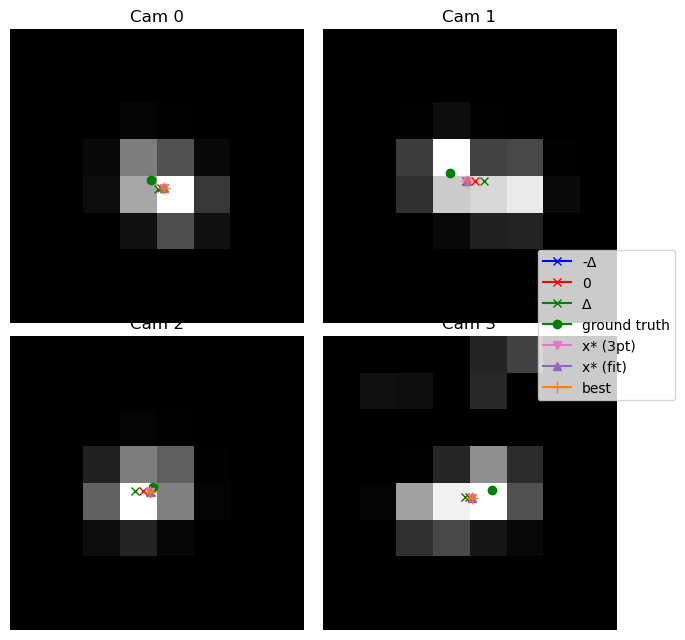

In [13]:
pt_center = obj_bf._pt_center
delta = tr_cfg._shake_param._shake_width
print(f"Δ'={delta:.4f}  ")
obj3d_tmp1 = lpt.Tracer3D(lpt.Pt3D(pt_center[0] - delta, pt_center[1], pt_center[2]), tr_cfg._radius_obj)
obj3d_tmp2 = lpt.Tracer3D(lpt.Pt3D(pt_center[0] + delta, pt_center[1], pt_center[2]), tr_cfg._radius_obj)
obj3d_tmp1.projectObject2D(cam_list)
obj3d_tmp2.projectObject2D(cam_list)

fig, axes = plt.subplots(rows, cols, figsize=(3.2*cols, 3.2*rows))
for k in range(n_cam):
    ax = get_ax(axes, k // cols, k % cols)
    aug_img = roi_all[k].getAugImg()
    aug_img = np.array(aug_img.to_list(), dtype = np.uint8)
    ax.imshow(aug_img, cmap="gray", interpolation="nearest", origin="upper")

    roi = roi_all[k]
    rmin, rmax = roi.ROI_range.row_min, roi.ROI_range.row_max
    cmin, cmax = roi.ROI_range.col_min, roi.ROI_range.col_max

    ax.plot(obj3d_tmp1._obj2d_list[k]._pt_center[0] - cmin, obj3d_tmp1._obj2d_list[k]._pt_center[1] - rmin, marker="x", color="blue",  markersize=6, label="-Δ")
    ax.plot(obj_bf._obj2d_list[k]._pt_center[0] - cmin, obj_bf._obj2d_list[k]._pt_center[1] - rmin, marker="x", color="red",   markersize=6, label="0")
    ax.plot(obj3d_tmp2._obj2d_list[k]._pt_center[0] - cmin, obj3d_tmp2._obj2d_list[k]._pt_center[1] - rmin, marker="x", color="green", markersize=6, label="Δ")
    ax.plot(obj_gt._obj2d_list[k]._pt_center[0] - cmin, obj_gt._obj2d_list[k]._pt_center[1] - rmin, marker="o", color="green",   markersize=6, label="ground truth")
    
    ax.set_title(f"Cam {k}")
    ax.set_axis_off()

shake_cam = shaker.strategy.selectShakeCam(obj_bf, roi_all, image_list)
residue1 = shaker.strategy.calShakeResidue(obj3d_tmp1, roi_all, shake_cam)
residue2 = shaker.strategy.calShakeResidue(obj_bf, roi_all, shake_cam)
residue3 = shaker.strategy.calShakeResidue(obj3d_tmp2, roi_all, shake_cam)
print(residue1, residue2, residue3)

# ========= 一次扩步 + “已在谷底就不扩步”门控（测试版，尽量精简）=========

# 起始三点（你前面已算好）
fL, f0, fR = residue1, residue2, residue3
xs, ys, objs = [-delta, 0.0, +delta], [fL, f0, fR], [obj3d_tmp1, obj_bf, obj3d_tmp2]

# —— 门控：若三点抛物线的极小值“明确在区间内”，且预测收益够小/够大，则直接收，不扩步 ——
# 三点解析量（几乎零开销）
kappa = (fL - 2.0*f0 + fR)                     # 二阶差分
g     = (fR - fL) / max(2.0*delta, 1e-12)      # 中心差分斜率
skip_expand = False
x3_used = False   # 是否评了三点极小值
x3 = None

if kappa > 0:  # 只有上凸才可信
    x3 = delta * (fL - fR) / (2.0 * kappa)     # 三点极小值位置（解析式）
    beta = 0.95                                 # “明确在内部”的安全裕度
    if abs(x3) <= beta * delta:
        # 用 g^2/(2a) 的闭式预测收益；a = kappa / Δ^2
        rho_pred = (g*g) / (2.0 * (kappa / max(delta,1e-12)**2) * max(f0, 1.0))
        eta_gate_small = 8e-4   # 很小的收益→连 x* 都不评，直接在三点里选
        eta_gate_eval  = 1.2e-3 # 中等以上收益→评一次 x*，但仍跳过扩步
        if rho_pred < eta_gate_small:
            skip_expand = True
        else:
            # 评一次 x3（ROI 检查）
            obj_x3 = lpt.Tracer3D(lpt.Pt3D(pt_center[0] + x3, pt_center[1], pt_center[2]), tr_cfg._radius_obj)
            obj_x3.projectObject2D(cam_list)
            out = False
            for k, use in enumerate(shake_cam):
                if not use: continue
                pt2 = obj_x3._obj2d_list[k]
                if pt2 is None: out = True; break
                p = pt2._pt_center; xx, yy = p[0], p[1]
                rr = roi_all[k].ROI_range
                if not (rr.col_min <= xx < rr.col_max and rr.row_min <= yy < rr.row_max):
                    out = True; break
            if not out:
                f_x3 = shaker.strategy.calShakeResidue(obj_x3, roi_all, shake_cam)
                xs.append(x3); ys.append(f_x3); objs.append(obj_x3)
                x3_used = True
                skip_expand = True
        print(f"[gate] kappa={kappa:.3g}, x3={x3:.4f}, rho_pred={rho_pred:.3g}, skip_expand={skip_expand}, x3_used={x3_used}")
    else:
        print(f"[gate] kappa={kappa:.3g}, x3={x3:.4f} (out of [-Δ,Δ]), skip_expand=False")
else:
    print(f"[gate] kappa={kappa:.3g} (not convex), skip_expand=False")

# —— 若未命中门控，才进行“一次扩步”（上凸外推 or 1px）+ ROI 0.5 限幅 ——
exp_ok = False
dx_exp = 0.0
if not skip_expand:
    # 单调性（只在单调时扩步）
    tol = 1e-3 * max(1.0, f0)
    mono_dec = (fL > f0 + tol) and (f0 > fR + tol)   # 随 x 增大单调下降：往 +x
    mono_inc = (fR > f0 + tol) and (f0 > fL + tol)   # 随 x 增大单调上升：往 -x
    expand_allowed = mono_dec or mono_inc
    s = (+1 if mono_dec else (-1 if mono_inc else 0))

    # 用已有三点估像素敏感度 Jx 与中心像素余量 mpx（中位数，零额外投影）
    Jvals, margins = [], []
    for k, use in enumerate(shake_cam):
        if not use: continue
        L = obj3d_tmp1._obj2d_list[k]; O = obj_bf._obj2d_list[k]; R = obj3d_tmp2._obj2d_list[k]
        if (L is None) or (O is None) or (R is None): continue
        pL, p0, pR = L._pt_center, O._pt_center, R._pt_center
        Jvals.append(np.hypot(pR[0]-pL[0], pR[1]-pL[1]) / max(2.0*delta, 1e-12))
        rr = roi_all[k].ROI_range
        margins.append(min(p0[0]-rr.col_min, rr.col_max-1-p0[0], p0[1]-rr.row_min, rr.row_max-1-p0[1]))
    Jx  = np.median(Jvals)  if Jvals  else 0.0
    mpx = np.median(margins) if margins else 0.0
    Delta_roi = (0.5 * mpx / max(Jx, 1e-12)) if (expand_allowed and Jx > 0 and mpx > 0) else 0.0

    # Δ_try：分支A（上凸外推，仅当 |x*|>Δ ）否则分支B（1px 法）
    Delta_try =  1.0 / Jx
    if expand_allowed and kappa > 0:
        xstarA = delta * (fL - fR) / (2.0 * kappa)
        if abs(xstarA) > delta:
            s = (1 if xstarA > 0 else -1)
            Delta_try = min(Delta_try, 1.15 * abs(xstarA))  # α≈1.1~1.2


    Delta_prime = min(Delta_try, Delta_roi) if (expand_allowed and Delta_try > 0.0 and Delta_roi > 0.0) else 0.0

    if Delta_prime > 0.0:
        dx_exp = s * Delta_prime
        obj_exp = lpt.Tracer3D(lpt.Pt3D(pt_center[0] + dx_exp, pt_center[1], pt_center[2]), tr_cfg._radius_obj)
        obj_exp.projectObject2D(cam_list)
        out = False
        for k, use in enumerate(shake_cam):
            if not use: continue
            pt2 = obj_exp._obj2d_list[k]
            if pt2 is None: out = True; break
            p = pt2._pt_center; xx, yy = p[0], p[1]
            rr = roi_all[k].ROI_range
            if not (rr.col_min <= xx < rr.col_max and rr.row_min <= yy < rr.row_max):
                out = True; break
        if not out:
            f_exp = shaker.strategy.calShakeResidue(obj_exp, roi_all, shake_cam)
            xs.append(dx_exp); ys.append(f_exp); objs.append(obj_exp)
            exp_ok = True
    print(f"[expand] allowed={expand_allowed}, Jx={Jx:.3f}, mpx={mpx:.2f}, Δ_roi={Delta_roi:.4f}, "
          f"Δ_try={Delta_try:.4f}, Δ'={Delta_prime:.4f}, exp_ok={exp_ok}")

# —— 统一收尾：对“已评样本”做一次二次拟合；a_fit<=0 直接取最小；a_fit>0 且 x̂ 在区间再评一次 ——
xs_arr = np.array(xs, float); ys_arr = np.array(ys, float)
a_fit, b_fit, c_fit = np.polyfit(xs_arr, ys_arr, deg=2)

use_fit = False
if a_fit > 0.0:
    x_hat = -b_fit / (2.0 * a_fit)
    if xs_arr.min() <= x_hat <= xs_arr.max():
        obj_fit = lpt.Tracer3D(lpt.Pt3D(pt_center[0] + x_hat, pt_center[1], pt_center[2]), tr_cfg._radius_obj)
        obj_fit.projectObject2D(cam_list)
        out = False
        for k, use in enumerate(shake_cam):
            if not use: continue
            pt2 = obj_fit._obj2d_list[k]
            if pt2 is None: out = True; break
            p = pt2._pt_center; xx, yy = p[0], p[1]
            rr = roi_all[k].ROI_range
            if not (rr.col_min <= xx < rr.col_max and rr.row_min <= yy < rr.row_max):
                out = True; break
        if not out:
            f_fit = shaker.strategy.calShakeResidue(obj_fit, roi_all, shake_cam)
            xs.append(x_hat); ys.append(f_fit); objs.append(obj_fit)
            use_fit = True

# —— 选最小并打印 —— 
best_dx, best_res, best_obj = min(zip(xs, ys, objs), key=lambda t: t[1])
print(f"[final] samples={[(round(x,4), round(y,3)) for x,y in zip(xs,ys)]}, "
      f"a_fit={a_fit:.3e}, x_hat={(x_hat if a_fit>0 else None)}, use_fit={use_fit}, "
      f"best_dx={best_dx:.4f}, best_res={best_res:.3f}")

# —— 可视化：扩步点 / 三点极小值 / 拟合极小值 / 最佳点 —— 
for k in range(n_cam):
    ax = get_ax(axes, k // cols, k % cols)
    rr = roi_all[k].ROI_range
    rmin, cmin = rr.row_min, rr.col_min

    # 扩步点
    if exp_ok:
        p = objs[-1]._obj2d_list[k] if xs[-1] == dx_exp else None  # 简单区分，可能不严谨但足够测试
        if p is not None:
            q = p._pt_center; xe, ye = q[0], q[1]
            ax.plot(xe - cmin, ye - rmin, marker="x", color="#6a5acd", markersize=6, label=("exp" if k==0 else None))

    # 三点极小值（若评过）
    if x3_used:
        # 找到 xs==x3 的对象
        try:
            idx = xs.index(x3)
            p = objs[idx]._obj2d_list[k]
            q = p._pt_center; xv, yv = q[0], q[1]
            ax.plot(xv - cmin, yv - rmin, marker="v", color="#e377c2", markersize=6, label=("x* (3pt)" if k==0 else None))
        except Exception:
            pass

    # 拟合极小值（若评过）
    if a_fit > 0 and use_fit:
        # 找到 xs==x_hat 的对象（浮点比较放宽）
        idxs = [i for i,xx in enumerate(xs) if abs(xx - x_hat) < 1e-9]
        if idxs:
            p = objs[idxs[0]]._obj2d_list[k]
            q = p._pt_center; xvf, yvf = q[0], q[1]
            ax.plot(xvf - cmin, yvf - rmin, marker="^", color="#9467bd", markersize=6, label=("x* (fit)" if k==0 else None))

    # 最佳点
    # 找到 best_obj 对应 2D
    p = best_obj._obj2d_list[k]; q = p._pt_center
    xb, yb = q[0], q[1]
    ax.plot(xb - cmin, yb - rmin, marker="+", color="#ff7f0e", markersize=8, label=("best" if k==0 else None))

# 图例放右侧外面
handles, labels = axes.flatten()[0].get_legend_handles_labels()
fig.subplots_adjust(right=0.82)
fig.legend(handles, labels, loc="center left", bbox_to_anchor=(0.84, 0.5), frameon=True)
plt.tight_layout()



In [ ]:
import pyopenlpt as lpt

config_file = '../../test/inputs/test_STB/config_python.txt'
with lpt.PythonStreamRedirector():
    lpt.run(config_file)

Estimating OTF...
Camera 0 (a,b,c,alpha) = 124.00,1.43,1.43,0.00

Camera 1 (a,b,c,alpha) = 124.00,1.43,1.43,0.00

Camera 2 (a,b,c,alpha) = 124.00,1.43,1.42,0.00

Camera 3 (a,b,c,alpha) = 124.00,1.44,1.42,0.00

**************
OpenLPT start!
**************

Initial phase at frame 0
START IPR...
Full cameras
Combination 0 cams=[0, 1, 2, 3]
		2D detections per active camera: 11679  11331  11462  11470   (0.01 s)
		Matched 9325 objects. ( 2D tol: 0.80, t:0.24 s)	After shaking: 9325 objects remain. (0.26 s)
	LOOP=0: TOTAL OBJECTS = 9325
		2D detections per active camera: 2192  2357  2577  2368   (0.00 s)
		Matched 817 objects. ( 2D tol: 1.20, t:0.02 s)	After shaking: 816 objects remain. (0.04 s)
	LOOP=1: TOTAL OBJECTS = 10141
Reduced cameras
Combination 0 cams=[0, 1, 2]
		2D detections per active camera: 1521  1548  1753   (0.00 s)
		Matched 470 objects. ( 2D tol: 0.80, t:0.01 s)	After shaking: 466 objects remain. (0.04 s)
	LOOP=0: TOTAL OBJECTS = 10607
		2D detections per active camera: 104

In [ ]:
import pyopenlpt as lpt

config_file = "D:/0.Code/Test/LPT_CASE01_TR_dt1/config.txt"
with lpt.PythonStreamRedirector():
    lpt.run(config_file)

Estimating OTF...
Camera 0 (a,b,c,alpha) = 1164.54,1.10,1.09,0.00

Camera 1 (a,b,c,alpha) = 1161.82,1.10,1.10,0.00

Camera 2 (a,b,c,alpha) = 1178.05,1.10,1.10,0.00

Camera 3 (a,b,c,alpha) = 1150.15,1.10,1.10,0.00

**************
OpenLPT start!
**************

Initial phase at frame 0
START IPR...
Full cameras
Combination 0 cams=[0, 1, 2, 3]
		2D detections per active camera: 53822  54260  53872  54070   (0.01 s)
		Matched 9869 objects. (3.58 s)	After shaking: 8798 objects remain. (0.27 s)
	LOOP=0: TOTAL OBJECTS = 8798
		2D detections per active camera: 46915  47685  47363  47324   (0.01 s)
		Matched 2413 objects. (3.31 s)	After shaking: 2155 objects remain. (0.11 s)
	LOOP=1: TOTAL OBJECTS = 10953
Reduced cameras
Combination 0 cams=[0, 1, 2]
		2D detections per active camera: 45572  45872  45106   (0.01 s)
		Matched 24792 objects. (3.74 s)	After shaking: 19552 objects remain. (0.59 s)
	LOOP=0: TOTAL OBJECTS = 30505
Combination 1 cams=[0, 1, 3]
		2D detections per active camera: 26933  2